<a href="https://colab.research.google.com/github/zctpig/Caltech-UCSD-Birds-200-2011/blob/master/KL_divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Test Split

In [98]:
!pip install scikit-image==0.14.3

In [99]:
import skimage
print(skimage.__version__)

0.14.3


In [100]:
!wget --no-check-certificate \
    http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-29 15:31:14--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]   1.07G  7.34MB/s    in 2m 42s  

2019-09-29 15:33:56 (6.77 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [1150585339/1150585339]



In [0]:
!tar -zxf /tmp/cats_and_dogs_filtered.zip -C /tmp/

In [0]:
PATH = '/tmp/CUB_200_2011/'

In [0]:
read_line = open(PATH + 'train_test_split.txt')

In [0]:
a = read_line.readlines()

In [105]:
a[0].split(' ')[1].split('\n')[0]

'0'

In [106]:
classes = open(PATH + 'classes.txt')
c_names = classes.readlines()
len(c_names)

200

In [0]:
for i in range(len(c_names)):
  c_names[i] = c_names[i].split(' ')[1]

In [108]:
c_names[0].split('\n')[0]

'001.Black_footed_Albatross'

In [0]:
import os
for i in range(len(c_names)):
    dir_name = PATH + 'test/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
for i in range(len(c_names)):
    dir_name = PATH + 'train/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms

In [0]:
train_dataset = datasets.ImageFolder(PATH + 'images')

In [0]:
from skimage import io

In [114]:
print(len(train_dataset.imgs))

11788


In [0]:
for j in range(len(train_dataset.imgs)):
    if(a[j].split(' ')[1].split('\n')[0] == '0'):
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'test/' + folder + '/' + img_name, img)
        os.remove(path)
    else:
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'train/' + folder + '/' + img_name, img)
        os.remove(path)

In [116]:
total = 0
for path, dirs, files in os.walk(PATH + 'train'):
    total += len(files)
print('train images number:', total)

train images number: 5994


In [117]:
total = 0
for path, dirs, files in os.walk(PATH + 'test'):
    total += len(files)
print('test images number:', total)

test images number: 5794


# Model

In [0]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [120]:
dataset_sizes

{'test': 5794, 'train': 5994}

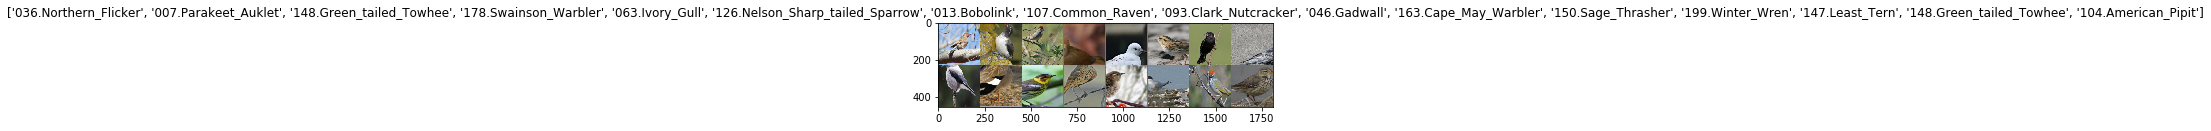

In [121]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [122]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
G_DRIVE = '/gdrive/My Drive/'

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                print(scheduler.get_lr())
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state, G_DRIVE + 'point_resnet_best.pth')
            
            if phase == 'train':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [0]:
class StemCNN(nn.Module):

    def __init__(self,pretrained=True):
        super().__init__()
        self.net = torchvision.models.resnet50(pretrained=pretrained)

    def forward(self, x):
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x = self.net.maxpool(x)

        x = self.net.layer1(x)
        x = self.net.layer2(x)
        x = self.net.layer3(x)
        return x


class SubNet(nn.Module):

    def __init__(self,pretrained=True):
        super().__init__()
        self.block = torchvision.models.resnet50(pretrained=True).layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # output:1,2048
    def forward(self, x):
        x = self.block(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        return x


class RefinedModel(nn.Module):

    def __init__(self, class_num=1000):
        super().__init__()
        self.stem_cnn = StemCNN()
        self.subnet1 = SubNet()
        self.subnet2 = SubNet()
        self.fc = nn.Linear(4096, class_num)

    def forward(self, x):
        x = self.stem_cnn(x)
        feature1, feature2 = self.subnet1(x), self.subnet2(x)
        x = torch.cat((feature1, feature2), 1)
        x = self.fc(x)
        return x, feature1, feature2

class BaseModel(nn.Module):

    def __init__(self, class_num=1000):
        super().__init__()
        self.stem_cnn = StemCNN()
        self.subnet1 = SubNet()
        self.fc = nn.Linear(2048, class_num)

    def forward(self, x):
        x = self.stem_cnn(x)
        x = self.subnet1(x)
        x = self.fc(x)
        return x


In [0]:
def train_refined_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, save_dir, num_epochs=10, use_gpu=True):
    """

    :param dataset_sizes:
    :param save_dir: dir to save model
    :param model:
    :param criterion:
    :param optimizer:
    :param scheduler:
    :param dataloaders:
    :param num_epochs:
    :param use_gpu:
    :return:
    """
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    kldiv_loss_func = nn.KLDivLoss(reduction='sum')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                print(scheduler.get_lr())
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                feature, feature_1, feature_2 = model(inputs)
                ce_loss = criterion(feature, labels)
                _, preds = torch.max(feature.data, 1)
                #print("##########")
                #print('pre_feature1:',feature1)
                feature1 = F.softmax(feature_1,1)
                #log_feature1 = F.log_softmax(feature_1,1)
                #print('post_feature1:', feature1)
                feature2 = F.softmax(feature_2,1)
                #log_feature2 = F.log_softmax(feature_2,1)
                kl_loss = (1-(kldiv_loss_func(feature1.log(), feature2) + kldiv_loss_func(feature2.log(), feature1))/2)*0.001
                
                loss = ce_loss+kl_loss
                
                #print('loss:',loss)
                #print('kl_loss:',kl_loss)
                #print('ce_loss:',ce_loss)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model': model.state_dict(), 'optim': optimizer.state_dict()}
                torch.save(state, save_dir + 'point_resnet_best.pth')

            if phase == 'train':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
refined_model= RefinedModel(class_num=200)
refined_model = refined_model.cuda()

In [130]:
x = torch.randn(1,3,256,256).cuda()
refined_model(x)[0].shape

torch.Size([1, 200])

In [0]:
criterion = nn.CrossEntropyLoss()           # defining loss function
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(refined_model.parameters(), lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, 30, gamma=0.1, last_epoch=-1)

In [132]:
refined_model = train_refined_model(refined_model, criterion, optimizer_ft, scheduler,dataloders,dataset_sizes,G_DRIVE, num_epochs=70)

Epoch 0/69
----------
[0.01]
train Loss: 0.2903 Acc: 0.0751
test Loss: 0.2388 Acc: 0.1628

Epoch 1/69
----------
[0.01]
train Loss: 0.2097 Acc: 0.2209
test Loss: 0.1816 Acc: 0.2936

Epoch 2/69
----------
[0.01]
train Loss: 0.1718 Acc: 0.3288
test Loss: 0.1425 Acc: 0.4304

Epoch 3/69
----------
[0.01]
train Loss: 0.1552 Acc: 0.3892
test Loss: 0.1473 Acc: 0.4206

Epoch 4/69
----------
[0.01]
train Loss: 0.1387 Acc: 0.4459
test Loss: 0.1246 Acc: 0.5045

Epoch 5/69
----------
[0.01]
train Loss: 0.1249 Acc: 0.4897
test Loss: 0.1289 Acc: 0.5198

Epoch 6/69
----------
[0.01]
train Loss: 0.1194 Acc: 0.5052
test Loss: 0.1105 Acc: 0.5597

Epoch 7/69
----------
[0.01]
train Loss: 0.1139 Acc: 0.5325
test Loss: 0.1135 Acc: 0.5482

Epoch 8/69
----------
[0.01]
train Loss: 0.1046 Acc: 0.5692
test Loss: 0.1115 Acc: 0.5782

Epoch 9/69
----------
[0.01]
train Loss: 0.1006 Acc: 0.5829
test Loss: 0.0990 Acc: 0.6227

Epoch 10/69
----------
[0.01]
train Loss: 0.0977 Acc: 0.5971
test Loss: 0.0975 Acc: 0.6234

In [0]:
 model_ft = models.resnet50(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
# model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters())

In [134]:
if os.path.exists(G_DRIVE + 'point_resnet_best.pth'):
    checkpoint = torch.load(G_DRIVE + 'point_resnet_best.pth')
    model_ft.load_state_dict(checkpoint['model'])
    optimizer_ft.load_state_dict(checkpoint['optim'])

RuntimeError: ignored

In [0]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, 30, gamma=0.1, last_epoch=-1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=90)

In [0]:
visualize_model(model_ft)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
        model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'test')

In [0]:
loss = nn.KLDivLoss()
batch_size = 5
aaa = torch.randn(batch_size, 10)
bbb = torch.randn(batch_size, 10)
log_probs1 = F.softmax(bbb)
#log_p = F.log_softmax(aaa)
probs2 = F.softmax(bbb)
m = loss(log_probs1.log(), probs2)
#print(torch.randn(batch_size, 10).shape)
print(aaa)
print(bbb)
print(m)

In [0]:
top1.avg

In [0]:
top5.avg